### Problem statement

Task 1 from the [QOSF Mentoship (September 2020)](https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit?pli=1)

Implement, on a quantum simulator of your choice, the following 4 qubits state $|\psi(\theta)\rangle$:

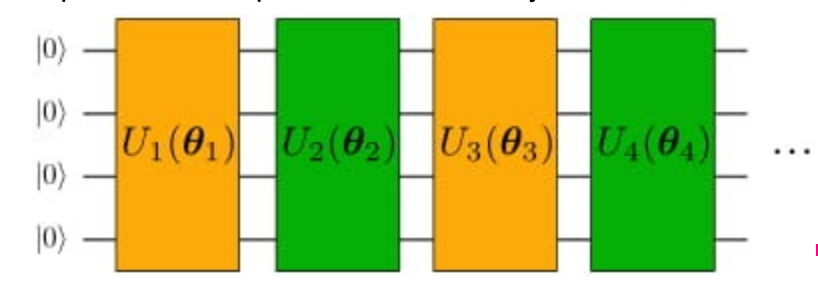


Where the number of layers, denoted with $L$, has to be considered as a parameter. We call "Layer" the combination of 1 yellow + 1 green block. U1 + U2 is a layer. The odd/even variational blocks are given by:

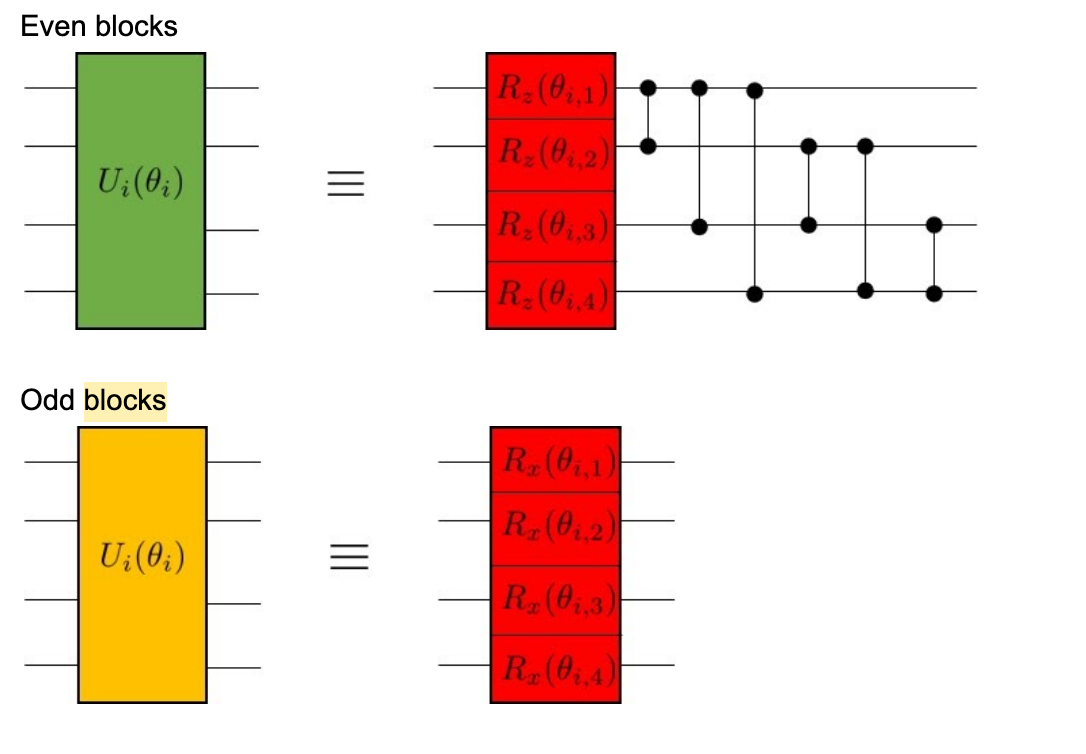

The angles $\theta_{i,n}$ are variational parameter, lying in the interval $(0, 2\pi)$ initialized at random. Double qubit gates are $CZ$ gates. Report with a plot, as a function of the number of layers, L the minimum distance

$\epsilon = \min_{\theta} |||\psi(\theta)\rangle-|\phi\rangle||$.

### Methodology:

We have a parameterized quantum circuit (PQC) of the form given above:

$$U(\theta)=\prod\limits_{i=1}^{L}U_{even}(\theta_i)U_{odd}(\theta_i)$$ 

In [13]:
import qiskit
import numpy as np
import itertools
import collections

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city

%matplotlib inline
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)

In [2]:
class LayeredAnsatzForArbitraryState:
    def __init__(self, layers=1, qubits=4):
        self.qr = QuantumRegister(qubits)
        self.cr = ClassicalRegister(qubits)
        self.len_qubits = len(self.qr)
        self.L = layers
        self.backend = Aer.get_backend("statevector_simulator")
        self.params_per_layer = self.len_qubits * 2
        self.total_params = self.params_per_layer * self.L
        return
    
    def _get_layer(self, params, forward=True):
        # define the even layer
        if forward:
            for param, qubit in zip(params, self.qr):
                self.circuit.rz(param, qubit)
            self.circuit.barrier()
            for idx in range(1, len(self.qr)):
                self.circuit.cz(self.qr[0], self.qr[idx])
            self.circuit.barrier()
            # define the odd layer
            for param, qubit in zip(params[self.len_qubits:], self.qr):
                self.circuit.rx(param, qubit)
            self.circuit.barrier()

    def set_initial_params(self, params):
        self.initial_params = params

    def _ansatz(self, params):
        self.circuit = QuantumCircuit(self.qr, self.cr)
        for idx in range(self.L):
            self._get_layer(params[idx * self.params_per_layer: (idx + 1) * self.params_per_layer])

    def state_vector(self, params):
        self._ansatz(params)
        wf = execute(self.circuit, self.backend).result().get_statevector() 
        return wf

In [3]:
phi_ansatz = LayeredAnsatzForArbitraryState()
phi_params = np.random.uniform(0, 2 * np.pi, (phi_ansatz.total_params,))

In [156]:
class Minimize:
    def __init__(self, phi_params):
        self.ansatz = LayeredAnsatzForArbitraryState()
        # the final statevector to achieve
        self.phi = self.ansatz.state_vector(phi_params)
    
    def _loss(self, circuit, params):
        psi = circuit.state_vector(params)
        diff = psi - self.phi
        loss = np.conj(diff).dot(diff)
        return np.sqrt(np.real(loss))
    
    # calculate the parameter shift gradient
    def gradient(self, circuit, params, lr, obj):
        mask = np.eye(params.shape[0]) * (0.25 * np.pi)
        right = params + mask
        left = params - mask
        
        for idx, (rx, lx) in enumerate(zip(right, left)):
            params[idx] -= lr * (obj(circuit, rx) - obj(circuit, lx))
        return params, obj(circuit, params)
    
    # perform gradient descent and update parameters.
    # TODO: implement convergence law to skip parameter updates after convergence
    def minimize(self, circuits, lr=0.1, itrs=100, verbose=False):
        min_history = []
        history = []
        for idx, circuit in enumerate(circuits):
            _history = []
            params = np.random.uniform(0, 2*np.pi, (circuit.total_params, ))
            minimum = 2 ** 32
            minparams = None
            for itr in range(itrs):
                params, loss_itr = self.gradient(circuit, params, lr, self._loss)
                _history.append(loss_itr)
                if verbose:
                    print(itr, loss_itr)
                if loss_itr < minimum:
                    minimum = loss_itr
                    minparams = params
            min_history.append(minimum)
            print("Circuit {} , minimum {}".format(idx + 1, minimum))
            history.append(_history)
        return min_history, history

    def experiment(self, layers=5):
        circuits = []
        for layer in range(1, layers + 1):
            circuits.append(LayeredAnsatzForArbitraryState(layers=layer))
        min_hist, hist = self.minimize(circuits, itrs=2000)
        ## Do all the plots here
        plt.title("$|||\psi(\\theta)>-|\phi>||$ vs Iterations")
        plt.xlabel("iterations")
        plt.ylabel("$|||\psi(\\theta)>-|\phi>||$")
        for idx, history in enumerate(hist):
            plt.semilogy(list(range(1, len(hist[0])+1)), history, label=idx+1)
        plt.legend(title="layers", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        
        plt.title("$\min_{\\theta} |||\psi(\\theta)>-|\phi>||$ vs layers")
        plt.xlabel("layers")
        plt.ylabel("$\min_{\\theta} |||\psi(\\theta)>-|\phi>||$")
        plt.xticks(np.arange(len(min_hist))+1)
        plt.semilogy(np.arange(len(min_hist))+1, min_hist)
        plt.show()

Circuit 1 , minimum 2.2429645843401167e-15
Circuit 2 , minimum 3.823104118859426e-15
Circuit 3 , minimum 1.6256921645698057e-07
Circuit 4 , minimum 0.0005220377436599048
Circuit 5 , minimum 0.0006523175341987516


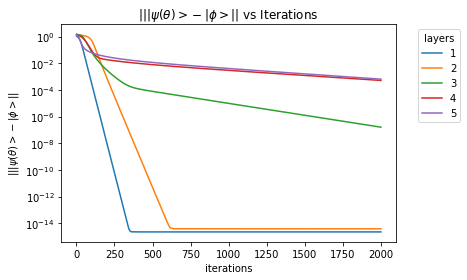

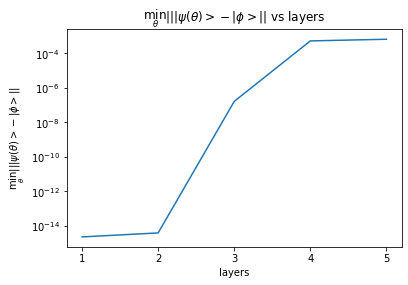

In [157]:
minimizer = Minimize(phi_params)
minimizer.experiment()

We see from the first graph above that the circuits with 1 and 2 layers converge with around 700 iterations, but circuits with layers more than three dont converge even after 2000 iterations. Would like to emphasize that in the latter we did not reach the barren plateau because we clearly see the loss is still decreasing and the probability of hitting a barren plateau with the number of parameters under 100 is rather low. The gradient descent algorithm above is not parallelized and its taking rather long to make each update for circuits with large number of parameters and decided to stop at 2000 iterations.

### References:

1. Broughton, Michael, et al. "Tensorflow quantum: A software framework for quantum machine learning." arXiv preprint arXiv:2003.02989 (2020).

2. Sweke, Ryan, et al. "Stochastic gradient descent for hybrid quantum-classical optimization." Quantum 4 (2020): 314.